In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from utils.get_sequences import get_sequences
from utils.split_data import split_data
from sklearn.preprocessing import StandardScaler
from data_files.data_module import EnergyChickenDataModule
from model_files.model import LSTM
from model_files.trainer import Trainer
from torch.optim import Adam, SGD, Adadelta, AdamW, Adagrad
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
RANDOM_SEED = 42
SPLITER_COUNT = 0.8
WINDOW_LENGHT = 24 * 7 * 4 # window size of one month
BATCH_SIZE = 32
MAX_COUNT_DECREASING = 10
LEARNING_RATE = 0.001
N_EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv('data_files/processed.csv')
df.drop(columns=df.columns[0], inplace=True)
scaler = StandardScaler()
data = torch.FloatTensor(scaler.fit_transform(df.iloc[:, 0].to_numpy().reshape((-1, 1)))).to(DEVICE)
sequences = get_sequences(data, WINDOW_LENGHT)
train, test = split_data(sequences, SPLITER_COUNT)

In [4]:
optimizers = [Adam, SGD, Adadelta, AdamW] # optimizers that we will test

In [5]:
comparison_logs = {}

for optimizer in optimizers:
    optimizer_name = str(optimizer).split('.')[-1][:-2]
    print(optimizer_name)

    data_module = EnergyChickenDataModule(train, test)
    data_module.setup()
    model = LSTM(device=DEVICE)
    optimizer = optimizer(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    trainer = Trainer(model=model, 
                    optimizer=optimizer, 
                    loss_function=criterion,
                    n_epochs=N_EPOCHS,
                    device=DEVICE,
                    max_count_decreasing=MAX_COUNT_DECREASING)

    train_dataloader = data_module.train_dataloader()
    test_dataloader = data_module.test_dataloader()
    trainer.upload_data(train_dataloader, test_dataloader)

    trainer.fit()
    
    comparison_logs[optimizer_name] = trainer.logs
    with open('compatison_results.json', 'w') as file:
        json.dump(comparison_logs, file, ensure_ascii=False, indent=4)
    

Adam


/home/argen7um/Desktop/code/energy_prediction/data_files/dataset.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.Tensor(sequence), torch.tensor(label).float())
/home/argen7um/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 train_loss 0.16901 test_loss 0.220407 time 70.807198
epoch 2 train_loss 0.117531 test_loss 0.138094 time 75.275218
epoch 3 train_loss 0.091537 test_loss 0.156205 time 72.386174
epoch 4 train_loss 0.079772 test_loss 0.117177 time 55.923169
epoch 5 train_loss 0.068531 test_loss 0.092732 time 60.705534
epoch 6 train_loss 0.094478 test_loss 0.162306 time 59.38107
epoch 7 train_loss 0.090058 test_loss 0.121635 time 61.043731
epoch 8 train_loss 0.078297 test_loss 0.099602 time 62.308078
epoch 9 train_loss 0.072494 test_loss 0.117325 time 61.0842
epoch 10 train_loss 0.069279 test_loss 0.086883 time 62.594113
SGD
epoch 1 train_loss 0.416799 test_loss 0.357041 time 54.182756
epoch 2 train_loss 0.221237 test_loss 0.255748 time 54.734307
epoch 3 train_loss 0.17262 test_loss 0.223836 time 53.983014
epoch 4 train_loss 0.16484 test_loss 0.219986 time 54.001846
epoch 5 train_loss 0.162764 test_loss 0.217845 time 54.892384
epoch 6 train_loss 0.160922 test_loss 0.216013 time 54.049899
epoch 7 t

train_loss 78.73265413832746
test_loss 76.70794126746199 


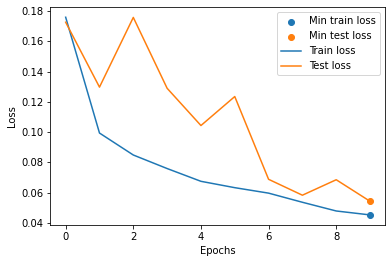

In [6]:

stat = trainer.logs
train_loss = stat['train_loss']
test_loss = stat['test_loss']
min_train_loss = min(train_loss)
min_train_loss_epoch = train_loss.index(min_train_loss)
min_test_loss = min(test_loss)
min_test_loss_epoch = test_loss.index(min_test_loss)
print(f'train_loss {(1-min_train_loss**0.5)*100}\ntest_loss {(1-min_test_loss**0.5)*100} ')

plt.scatter([min_train_loss_epoch], [min_train_loss], label='Min train loss')
plt.scatter([min_test_loss_epoch], [min_test_loss], label='Min test loss')
plt.plot(train_loss, label='Train loss')
plt.plot(test_loss, label='Test loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [7]:
print(str(AdamW).split('.')[-1][:-2])

AdamW
